# EJERCICIOS

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Concatenate
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError as RMSE

2025-02-04 18:36:54.161871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 18:36:54.169717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 18:36:54.180568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 18:36:54.183555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 18:36:54.191539: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [3]:
# Verifica si TensorFlow detecta la GPU
if tf.config.list_physical_devices('GPU'):
    print("¡GPU encontrada!")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("¡GPU no encontrada!")

¡GPU encontrada!
Num GPUs Available:  1


I0000 00:00:1738690620.772788   45706 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738690620.801820   45706 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738690620.802021   45706 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## EJERCICIO 1


Supongamos que queremos predecir dos objetivos diferentes (por ejemplo, precio y categoría) a partir de dos conjuntos de características diferentes (por ejemplo, características visuales y características de texto de un producto).

* Características visuales: un conjunto de 128 características numéricas, que podrían representar, por ejemplo, valores de píxeles o características extraídas de imágenes.
* Características de texto: un conjunto de 256 características numéricas, representando posiblemente la codificación de texto o características lingüísticas.
* Precio (Salida 1): un valor numérico que representa el precio de un producto.
* Categoría (Salida 2): una etiqueta de categoría, que asumiremos que puede tomar 10 valores diferentes (por ejemplo, 10 categorías diferentes de productos).

Voy a generar datos aleatorios

In [17]:
# Generación de datos ficticios
num_muestras = 1000  # Número de muestras en el conjunto de datos

# Características visuales: 128 características numéricas (x1)
caracteristicas_visuales = np.random.rand(num_muestras, 128)

# Características de texto: 256 características numéricas (x2)
caracteristicas_texto = np.random.rand(num_muestras, 256)

# Precio (Salida 1): Valor numérico (por ejemplo, precio de un producto) (y1)
precio = np.random.rand(num_muestras, 1)

# Categoría (Salida 2): 10 categorías posibles (codificadas en one-hot) y2
categorias = np.random.randint(0, 10, size=(num_muestras, 1))
categorias_one_hot = tf.keras.utils.to_categorical(categorias, num_classes=10)

Divide los datos en entrenamiento y prueba

In [18]:
x_temp_vis, x_test_vis, x_temp_txt, x_test_txt, y_temp_prec, y_test_prec, y_temp_cat, y_test_cat = train_test_split(
    caracteristicas_visuales,
    caracteristicas_texto,
    precio,
    categorias_one_hot,
    test_size=0.15,
    random_state=17)


x_train_vis, x_val_vis, x_train_txt, x_val_txt, y_train_prec, y_val_prec, y_train_cat, y_val_cat = train_test_split(
    x_temp_vis,
    x_temp_txt,
    y_temp_prec,
    y_temp_cat,
    test_size=0.15,
    random_state=17)

In [19]:
print("x_train_vis:",x_train_vis.shape)
print("x_val_vis:",x_val_vis.shape)
print("x_test_vis:",x_test_vis.shape)

print("y_train_prec:",y_train_prec.shape)
print("y_val_prec:",y_val_prec.shape)
print("y_test_prec:",y_test_prec.shape)

print("-------------------------------------------")

print("x_train_txt:",x_train_txt.shape)
print("x_val_txt:",x_val_txt.shape)
print("x_test_txt:",x_test_txt.shape)

print("y_train_cat:",y_train_cat.shape)
print("y_val_cat:",y_val_cat.shape)
print("y_test_cat:",y_test_cat.shape)

x_train_vis: (722, 128)
x_val_vis: (128, 128)
x_test_vis: (150, 128)
y_train_prec: (722, 1)
y_val_prec: (128, 1)
y_test_prec: (150, 1)
-------------------------------------------
x_train_txt: (722, 256)
x_val_txt: (128, 256)
x_test_txt: (150, 256)
y_train_cat: (722, 10)
y_val_cat: (128, 10)
y_test_cat: (150, 10)


Construye el modelo:
* Crea dos ramas de entrada, una para cada tipo de características.
* Las ramas se fusionarán para predecir el precio.
* Una de las ramas se utilizará también para predecir la categoria.

El esquema es el siguiente:

<img src="./esquema_modelo_funcional.png" alt="esquema modelo funcional"/>

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

input_layer_visual = tf.keras.layers.Input(shape=[128],name="Input_Visual") 
input_layer_texto = tf.keras.layers.Input(shape=[256],name="Input_Texto")  
hidden_layer_visual = tf.keras.layers.Dense(64,name="Oculta_Visual",activation="relu")
hidden_layer_texto = tf.keras.layers.Dense(128,name="Oculta_Texto",activation="relu")
output_layer_categorico = tf.keras.layers.Dense(10,activation="softmax",name="Salida_categorica")
output_layer_precio = tf.keras.layers.Dense(1,name="Salida_precio")

hidden_visual = hidden_layer_visual(input_layer_visual)
hidden_texto = hidden_layer_texto(input_layer_texto)
concat = tf.keras.layers.Concatenate()([hidden_visual, hidden_texto])
output_categorico = output_layer_categorico(hidden_texto)
output_precio = output_layer_precio(concat)

model = tf.keras.Model(inputs=[input_layer_visual, input_layer_texto], outputs=[output_categorico, output_precio])

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Texto         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Visual        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oculta_Texto        │ (None, 128)       │     32,896 │ Input_Texto[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Oculta_Visual       │ (None, 64)        │      8,256 │ Input_Visual[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ Oculta_Visual[0]… │
│ (Concatenate)       │                   │            │ Oculta_Texto[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Salida_categorica   │ (None, 10)        │      1,290 │ Oculta_Texto[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Salida_precio       │ (None, 1)         │        193 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,635 (166.54 KB)

 Trainable params: 42,635 (166.54 KB)

 Non-trainable params: 0 (0.00 B)

Comprueba creando una imagen del modelo que es igual que el que se pide

In [23]:
tf.keras.utils.plot_model(model, "resultados4_7/modelo_ejer1.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Compila el modelo especificando las pérdidas y métricas para cada salida (utiliza el optimizador Adam)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss={
        "Salida_categorica": "categorical_crossentropy",  # Clasificación
        "Salida_precio": "mse"  # Regresión
    },
    metrics={
        "Salida_categorica": ["accuracy"],  # Clasificación
        "Salida_precio": ["mae"]  # Regresión
    }
)


Entrena el modelo 

In [11]:
history=model.fit(
    [x_train_vis, x_train_txt],
    [y_train_cat, y_train_prec],
    epochs=30,
    batch_size=32,
    validation_data=((x_val_vis, x_val_txt), (y_val_cat, y_val_prec))
)

Epoch 1/30


/home/iabd/anaconda3/envs/IABD3_12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Input_Visual', 'Input_Texto']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1738679504.542652    9406 service.cc:146] XLA service 0x75b680004c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738679504.542697    9406 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-02-04 15:31:44.577490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-04 15:31:44.701603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100


 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Salida_categorica_accuracy: 0.0875 - Salida_categorica_loss: 2.4713 - Salida_precio_loss: 0.3528 - Salida_precio_mae: 0.4807 - loss: 2.7989

I0000 00:00:1738679505.832723    9406 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - Salida_categorica_accuracy: 0.0931 - Salida_categorica_loss: 2.4021 - Salida_precio_loss: 0.2913 - Salida_precio_mae: 0.4349 - loss: 2.6934 - val_Salida_categorica_accuracy: 0.1063 - val_Salida_categorica_loss: 2.3369 - val_Salida_precio_loss: 0.1757 - val_Salida_precio_mae: 0.3451 - val_loss: 2.5126
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Salida_categorica_accuracy: 0.1239 - Salida_categorica_loss: 2.3123 - Salida_precio_loss: 0.1347 - Salida_precio_mae: 0.3004 - loss: 2.4469 - val_Salida_categorica_accuracy: 0.1250 - val_Salida_categorica_loss: 2.3198 - val_Salida_precio_loss: 0.1639 - val_Salida_precio_mae: 0.3355 - val_loss: 2.4836
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Salida_categorica_accuracy: 0.1545 - Salida_categorica_loss: 2.2678 - Salida_precio_loss: 0.1122 - Salida_precio_mae: 0.2729 - loss: 2.3801 - val_Salida_categorica_accuracy: 0.1187 - val_Salida_categorica_loss: 2.3234 - val_Salida_precio_loss: 0.1448

Evalúa el modelo en el conjunt de pruebas

In [12]:
model.evaluate(
    [x_test_vis, x_test_txt],  # Entradas de prueba
    [y_test_cat, y_test_prec]  # Salidas de prueba
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - Salida_categorica_accuracy: 0.0757 - Salida_categorica_loss: 2.8149 - Salida_precio_loss: 0.1630 - Salida_precio_mae: 0.3374 - loss: 2.9726  


[2.9602930545806885,
 2.8455650806427,
 0.14175726473331451,
 0.07999999821186066,
 0.3165743350982666]

## EJERCICIO 2

El objetivo de este ejercicio es entrenar un modelo en un subconjunto de clases (Modelo A) y luego usar este modelo para entrenar otro modelo en un subconjunto diferente de clases (Modelo B), primero sin y luego con el conocimiento transferido del Modelo A.

Carga los datos de CIFAR-10, representa alguna de sus imágenes con sus etiquetas, haz una lista con las etiquetas que tiene (busca en internet) y normaliza los datos dividiendo entre 255.0.

Divide los datos en conjuntos de entrenamiento, pruebas y validación para el modelo A y para el modelo B:
* El modelo A utiliza las clases "avión", "automóvil", "pájaro" y "gato" (0,1,2,3)
* El modelo B utiliza las clases "ciervo", "perro", "rana" y "caballo" (4,5,6,7)

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [24]:
dicc={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [25]:
x_total = np.concatenate((x_train, x_test))
y_total = np.concatenate((y_train, y_test))

y_total_flat = y_total.flatten()

# Creamos las máscaras booleanas
mask_A = (y_total_flat >= 0) & (y_total_flat < 4)  # Valores [0, 1, 2, 3]
mask_B = (y_total_flat >= 4) & (y_total_flat < 8)  # Valores [4, 5, 6, 7]


# Usamos las máscaras para separar los datos
x_total_A = x_total[mask_A]
y_total_A = y_total[mask_A]

x_total_B = x_total[mask_B]
y_total_B = y_total[mask_B]


# Verificamos los resultados
print(f"Grupo A: {x_total_A.shape}, {y_total_A.shape}")
print(f"Grupo B: {x_total_B.shape}, {y_total_B.shape}")


# Dividir el conjunto completo en 50,000 para entrenamiento y 10,000 para validación + test
x_train_A, x_temp_A, y_train_A, y_temp_A = train_test_split(x_total_A, y_total_A, test_size=10000, random_state=17)

# Dividir los 10,000 restantes en 5,000 para validación y 5,000 para test
x_val_A, x_test_A, y_val_A, y_test_A = train_test_split(x_temp_A, y_temp_A, test_size=5000, random_state=17)

x_train_B, x_temp_B, y_train_B, y_temp_B = train_test_split(x_total_B, y_total_B, test_size=10000, random_state=17)

# Dividir los 10,000 restantes en 5,000 para validación y 5,000 para test
x_val_B, x_test_B, y_val_B, y_test_B = train_test_split(x_temp_B, y_temp_B, test_size=5000, random_state=17)


Grupo A: (24000, 32, 32, 3), (24000, 1)
Grupo B: (24000, 32, 32, 3), (24000, 1)


In [26]:
x_train_A = x_train_A.astype('float32') / 255.0
x_val_A = x_val_A.astype('float32') / 255.0
x_test_A = x_test_A.astype('float32') / 255.0

x_train_B = x_train_B.astype('float32') / 255.0
x_val_B = x_val_B.astype('float32') / 255.0
x_test_B = x_test_B.astype('float32') / 255.0

/tmp/ipykernel_45706/2878772641.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(dicc[int(y_train_A[idx])])


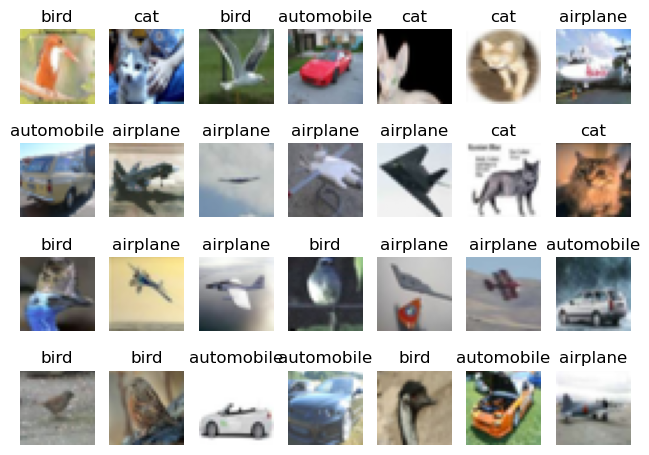

In [29]:

for idx,x in enumerate(x_train_A,start=0):
    plt.subplot(4,7,idx+1)
    plt.title(dicc[int(y_train_A[idx])])
    plt.imshow(x)
    plt.axis('off')
   
    if idx == 27:
        break
plt.tight_layout()
plt.show()

/tmp/ipykernel_45706/838667718.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(dicc[int(y_train_B[idx])])


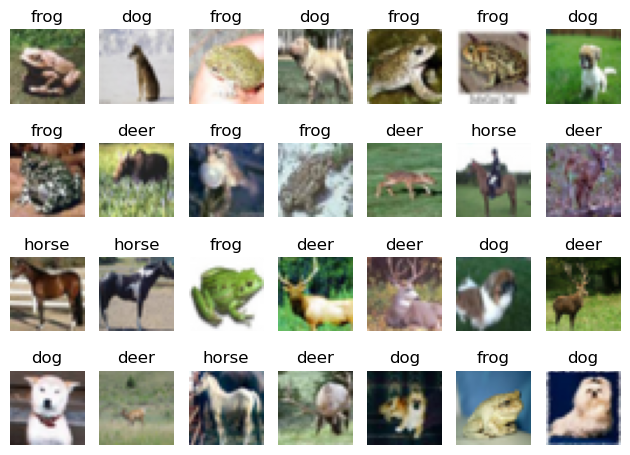

In [30]:
for idx,x in enumerate(x_train_B,start=0):
    plt.subplot(4,7,idx+1)
    plt.title(dicc[int(y_train_B[idx])])
    plt.imshow(x)
    plt.axis('off')
   
    if idx == 27:
        break
plt.tight_layout()
plt.show()

Entrena el Modelo A

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

In [32]:
model_A = Sequential(
        [
            Input(shape=(32, 32,3)),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(4, activation="sigmoid"),
        ]
)



model_A.compile(loss="sparse_categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

In [33]:
history_A=model_A.fit(x_train_A, y_train_A, epochs=75, validation_data=(x_val_A, y_val_A),callbacks=early_stopping_cb)
model_A.save("resultados4_7/my_model_A.keras")

Epoch 1/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3793 - loss: 1.3275 - val_accuracy: 0.4924 - val_loss: 1.2124
Epoch 2/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5190 - loss: 1.1886 - val_accuracy: 0.5492 - val_loss: 1.1299
Epoch 3/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.5572 - loss: 1.1118 - val_accuracy: 0.5746 - val_loss: 1.0763
Epoch 4/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.5762 - loss: 1.0624 - val_accuracy: 0.5878 - val_loss: 1.0407
Epoch 5/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.5930 - loss: 1.0301 - val_accuracy: 0.5974 - val_loss: 1.0157
Epoch 6/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6070 - loss: 1.0060 - val_accuracy: 0.6054 - val_loss: 0.9952
Epoch 7/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6184 - loss: 0.9865 - val_accuracy: 0.6096 - val_loss: 0.9788
Epoch 8/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.6279 - loss: 0.9699 - va

Entrenar el Modelo B desde 0

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.Adam()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

In [35]:
model_B = Sequential(
        [
            Input(shape=(32, 32,3)),
            Flatten(),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(4, activation="sigmoid"),
        ]
)



model_B.compile(loss="sparse_categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

In [36]:
history_B=model_B.fit(x_train_B, y_train_B-4, epochs=75, validation_data=(x_val_B, y_val_B-4),callbacks=early_stopping_cb)

Epoch 1/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3810 - loss: 1.3265 - val_accuracy: 0.5124 - val_loss: 1.1321
Epoch 2/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.5062 - loss: 1.1337 - val_accuracy: 0.5426 - val_loss: 1.0863
Epoch 3/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5528 - loss: 1.0554 - val_accuracy: 0.5584 - val_loss: 1.0399
Epoch 4/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.5758 - loss: 1.0127 - val_accuracy: 0.5752 - val_loss: 1.0153
Epoch 5/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.5959 - loss: 0.9792 - val_accuracy: 0.5684 - val_loss: 1.0166
Epoch 6/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6033 - loss: 0.9569 - val_accuracy: 0.5756 - val_loss: 1.0097
Epoch 7/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.6106 - loss: 0.9322 - val_accuracy: 0.5862 - val_loss: 0.9867
Epoch 8/75
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6274 - loss: 0.9114 - va

Entrenar el Modelo B utilizando las capas aprendidas del Modelo A (excepto la capa de salida)

In [42]:
tf.keras.backend.clear_session()
tf.random.set_seed(17)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

In [43]:
# Se transfieren todas las capas menos la última del modelo A al modelo B
clone_A = tf.keras.models.clone_model(model_A)
clone_A.set_weights(model_A.get_weights())
model_B_on_A = tf.keras.Sequential(clone_A.layers[:-1])    # todas las capas menos ultima
model_B_on_A.add(tf.keras.layers.Dense(4, activation="softmax",name="salida"))    # crear ultuma capa

# Congelamos las capas copiadas
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False


# compilar y entrenar
model_B_on_A.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
hist_B_on_A = model_B_on_A.fit(x_train_B, y_train_B-4, epochs=40, validation_data=(x_val_B, y_val_B-4))




Epoch 1/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3523 - loss: 1.3616 - val_accuracy: 0.4216 - val_loss: 1.2579
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.4369 - loss: 1.2431 - val_accuracy: 0.4404 - val_loss: 1.2325
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.4594 - loss: 1.2191 - val_accuracy: 0.4532 - val_loss: 1.2168
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4751 - loss: 1.2036 - val_accuracy: 0.4616 - val_loss: 1.2054
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.4824 - loss: 1.1919 - val_accuracy: 0.4712 - val_loss: 1.1965
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.4906 - loss: 1.1826 - val_accuracy: 0.4768 - val_loss: 1.1893
Epoch 7/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.4966 - loss: 1.1750 - val_accuracy: 0.4806 - val_loss: 1.1834
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.5020 - loss: 1.1686 - val_

In [44]:
   
model_B_on_A.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,646 (3.20 MB)

 Trainable params: 516 (2.02 KB)

 Non-trainable params: 836,096 (3.19 MB)

 Optimizer params: 1,034 (4.04 KB)

Descongelamos solo las 3 últimas cápas que son las que menos parametros tienen

In [45]:
# decongelar capas y volver a compilar y entrenar
for layer in model_B_on_A.layers[:-3]:
    layer.trainable = True

model_B_on_A.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
hist_B_on_A = model_B_on_A.fit(x_train_B, y_train_B-4, epochs=50, validation_data=(x_val_B, y_val_B-4))

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3870 - loss: 1.6831 - val_accuracy: 0.4158 - val_loss: 1.9885
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.4685 - loss: 1.3051 - val_accuracy: 0.4164 - val_loss: 1.8533
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.4945 - loss: 1.2453 - val_accuracy: 0.4270 - val_loss: 1.5080
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.5186 - loss: 1.1526 - val_accuracy: 0.4870 - val_loss: 1.1980
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.5437 - loss: 1.1014 - val_accuracy: 0.5180 - val_loss: 1.1967
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.5596 - loss: 1.0681 - val_accuracy: 0.5426 - val_loss: 1.0904
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.5742 - loss: 1.0381 - val_accuracy: 0.5234 - val_loss: 1.1484
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.5697 - loss: 1.0404 - va

Evaluar los dos modelos para el conjunto de datos B en el conjunto de pruebas

In [46]:
eval_A = model_A.evaluate(x_test_A,y_test_A)
print('Evaluacion Modelo A desde 0',eval_A,'\n')

eval_B = model_B.evaluate(x_test_B,y_test_B-4)
print('Evaluacion Modelo B desde 0',eval_B,'\n')

eval_B_on_A = model_B_on_A.evaluate(x_test_B,y_test_B-4)
print('Evaluacion Modelo B con capas de A',eval_B_on_A)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.6901 - loss: 0.8242
Evaluacion Modelo A desde 0 [0.8304119110107422, 0.6826000213623047] 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.5980 - loss: 0.9891
Evaluacion Modelo B desde 0 [0.9809320569038391, 0.5979999899864197] 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.5744 - loss: 1.2110
Evaluacion Modelo B con capas de A [1.2157493829727173, 0.5667999982833862]


¿En este caso merece la pena?

no tiene demaisado sentido entrenar un modelo con un conjunto, congelarlo y probarlo con otro totalmente distinto, los resultados son peores que los del modelo B "normal".